In [31]:
#Notebook's settings
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

#from jupyterthemes import jtplot
#jtplot.reset()

# Plotting

import sys
Folder='/Users/egordanilov/Desktop/Lesta_shared/GRF_strong_lensing/jax-strong-lensing/'
sys.path.append(Folder)

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
#%matplotlib inline


# Basic imports
import numpy as np
from copy import deepcopy
import pandas as pd
from tqdm import tqdm
import math
import time

#JAX
import jax
import jax.numpy as jnp
from jax.config import config
config.update("jax_enable_x64", True)
config.update("jax_debug_nans", True)

from GRF_perturbations.Modules.Data_generation import Observation_conditions_class
from GRF_perturbations.Modules.Image_processing import scipy_fit_image,compute_radial_spectrum
from GRF_perturbations.Modules.Jax_Utils import purify_function
from GRF_perturbations.Modules.Inference import distribution_Noise_LogSpectrum,compute_SNR_grid,Inference_pipeline,plot_likelihood


#Fontsize
FS=18

# Observation conditions

In [16]:
pixel_number=100
pixel_scale=0.08

PSF_FWHM=0.1 #arcsec, PSF of HST
exposure_time=2028 #COSMOS exposure
SNR=200 #75th percentile of COSMOS gaussian noise distribution 

Observation_conditions=Observation_conditions_class(pixel_number,pixel_scale,PSF_FWHM,SNR,exposure_time)

get_GRF=Observation_conditions.GRF_getter
simulate_perturbed_image=Observation_conditions.perturbed_image_getter
simulate_unperturbed_image=Observation_conditions.unperturbed_image_getter
simulate_unperturbed_image_pure=lambda kwargs: simulate_unperturbed_image(kwargs,Noise_flag=False)
compute_radial_spectrum_pure=purify_function(compute_radial_spectrum,Observation_conditions.annulus_mask,Observation_conditions.init_freq_index)

noise_var=Observation_conditions.noise_var
parameters=Observation_conditions.parameters
Estimated_Noise_spectral_density=(noise_var*Observation_conditions.annulus_mask).sum()/Observation_conditions.annulus_mask.sum()

# Unperturbed image

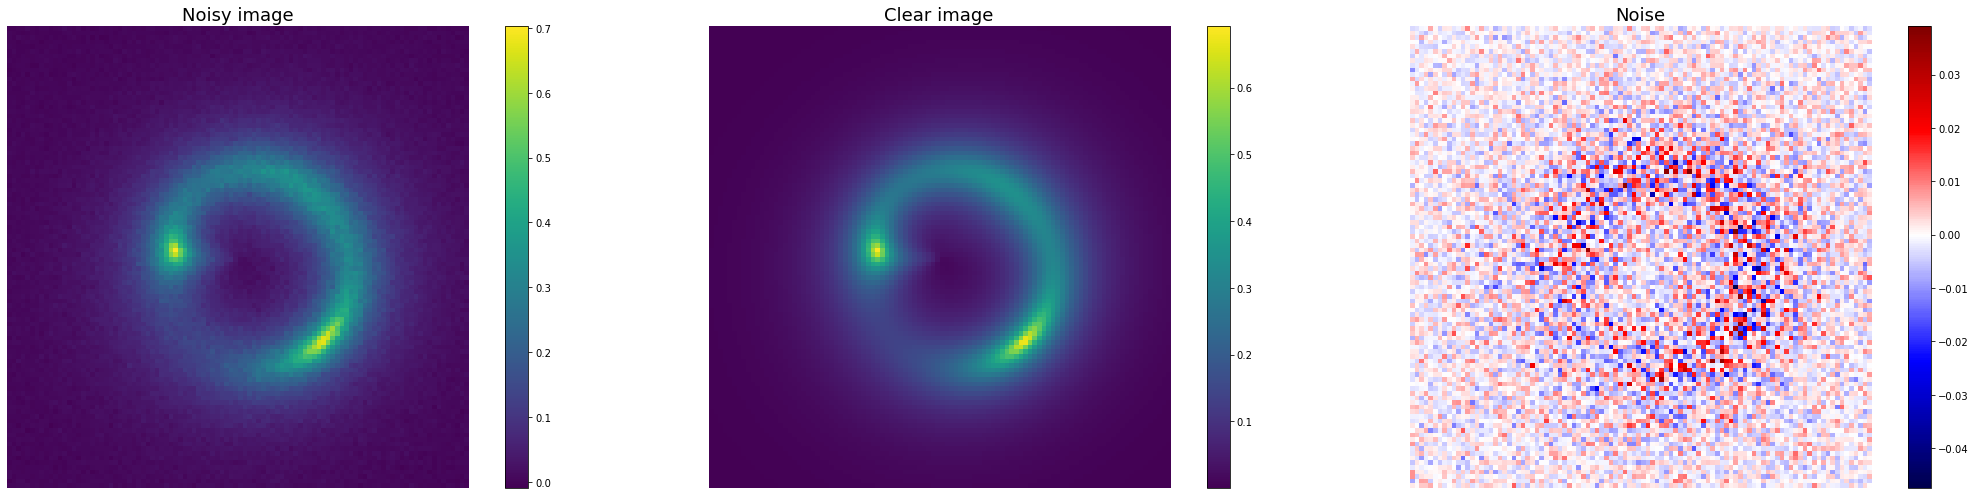

In [3]:
simulate_unperturbed_image=Observation_conditions.unperturbed_image_getter
Image_unperturbed_noiseless=simulate_unperturbed_image(Observation_conditions.kwargs_data,Noise_flag=False)
Image_unperturbed_noisy=simulate_unperturbed_image(Observation_conditions.kwargs_data,Noise_flag=True,noise_seed=42)

fig,ax=plt.subplots(1,3,figsize=(30,7))

img_arr=[]

img_arr+=[ax[0].imshow(Image_unperturbed_noisy)]
img_arr+=[ax[1].imshow(Image_unperturbed_noiseless)]
img_arr+=[ax[2].imshow(Image_unperturbed_noisy-Image_unperturbed_noiseless,cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))]

titles=['Noisy image','Clear image','Noise']

for i,axis in enumerate(ax):
    axis.set_title(titles[i],fontsize=FS)
    axis.axis('off')
    fig.colorbar(img_arr[i],ax=axis)

plt.tight_layout()
plt.show()

# GRF Spectra grid

In [6]:
logA_center_array=np.linspace(-9,-6.75,96)
Beta_center_array=np.linspace(1,5,96)

logA_step=logA_center_array[1]-logA_center_array[0]
Beta_step=Beta_center_array[1]-Beta_center_array[0]

Beta_min=1-math.floor(1/Beta_step)*Beta_step

Beta_long_array=np.arange(Beta_min,9,step=Beta_step)
Beta_left_array=np.arange(Beta_min,1,step=Beta_step)
Beta_right_array=np.arange(5+Beta_step,9,step=Beta_step)

logA_up_array=np.arange(-6.75+logA_step,-6.75+logA_step*33,step=logA_step)
logA_down_array=np.arange(-9-logA_step*32,-9,step=logA_step)

def load_zipped_tensors(directory,tensor_name,nodes,batches):
    tensor_array=[]
    
    Spectra_grid=[]
    for node in range(nodes):
        Spectra_node_grid=np.load(directory+'{}_node_{}_batch_0.npz'.format(tensor_name,node))['arr_0']
        for batch in range(1,batches):
            next_grid=np.load(directory+'{}_node_{}_batch_{}.npz'.format(tensor_name,node,batch))
            Spectra_node_grid=np.append(Spectra_node_grid,next_grid['arr_0'],axis=0)
            
        if node==0:
            Spectra_grid=Spectra_node_grid
        else:
            Spectra_grid=np.append(Spectra_grid,Spectra_node_grid,axis=1)
        #Spectra_grid_list+=[Spectra_node_grid]
    
    return Spectra_grid

#Central grid
Spectra_central_fine_grid=load_zipped_tensors('data/Spectra_grid_static_noise/Central_grid/','Spectra_grid',16,3)

#Top/bottom grid
Spectra_top_bot_grid=np.load('data/Spectra_grid_static_noise/Top_bottom_grid/Spectra_grid_node_0.npz')
logA_merged_array=np.append(logA_down_array,logA_up_array)

Spectra_top_grid=Spectra_top_bot_grid['arr_0'][32:]
Spectra_bot_grid=Spectra_top_bot_grid['arr_0'][:32]

#Central left/right grid
Spectra_left_right_grid=load_zipped_tensors('data/Spectra_grid_static_noise/Left_Right_grid/','Spectra_grid',1,3)
Spectra_left_grid=Spectra_left_right_grid[:,:len(Beta_left_array)]
Spectra_right_grid=Spectra_left_right_grid[:,len(Beta_left_array):]

#Combined grid
Spectra_central_grid=np.append(Spectra_left_grid,Spectra_central_fine_grid,axis=1)
Spectra_central_grid=np.append(Spectra_central_grid,Spectra_right_grid,axis=1)

Spectra_full_grid=np.append(Spectra_bot_grid,Spectra_central_grid,axis=0)
Spectra_full_grid=np.append(Spectra_full_grid,Spectra_top_grid,axis=0)

logA_full_array=np.append(logA_down_array,logA_center_array)
logA_full_array=np.append(logA_full_array,logA_up_array)

Beta_full_array=np.append(Beta_left_array,Beta_center_array)
Beta_full_array=np.append(Beta_full_array,Beta_right_array)

print('Spectra grid shape', Spectra_full_grid.shape)
print('log(A) array len', len(logA_full_array))
print('Beta array len',len(Beta_full_array))

del Spectra_central_fine_grid; del Spectra_top_bot_grid; del Spectra_top_grid ;del Spectra_bot_grid; del Spectra_left_right_grid; del Spectra_left_grid; del Spectra_right_grid; del Spectra_central_grid
del logA_center_array; del logA_down_array; del logA_merged_array; del logA_up_array; del logA_step
del Beta_center_array; del Beta_left_array; del Beta_long_array; del Beta_right_array; del Beta_min; del Beta_step

Spectra grid shape (160, 214, 100, 46)
log(A) array len 160
Beta array len 214


In [7]:
logA_array=deepcopy(logA_full_array)
Beta_array=deepcopy(Beta_full_array)

Spectra_grid=deepcopy(Spectra_full_grid)

y_labels=np.round(logA_array,2)
x_labels=np.round(Beta_array,2)

num_ticks = 8
# the index of the position of yticks
ticks = np.linspace(0, len(logA_array) - 1, num_ticks, dtype=int)
# the content of labels of these yticks
xticklabels = np.round([x_labels[idx] for idx in ticks],2)
yticklabels = np.round([y_labels[idx] for idx in ticks],2)

def set_labels(im):
    im.set_yticks(ticks)
    im.set_yticklabels(yticklabels)
    im.set_xticks(ticks)
    im.set_xticklabels(xticklabels)

def set_labels_plt(fontsize):
    plt.gca().set_yticklabels(yticklabels,fontsize=fontsize)
    plt.gca().set_xticklabels(xticklabels,fontsize=fontsize)

# Data generator

In [29]:
def generate_data(GRF_params,GRF_seed,fit=True):
    
    #Generate data and fit it

    #this is the true perturbation of the lens potential
    GRF_potential=get_GRF(GRF_params,GRF_seed)

    #data_image will play the role of the observed lens, that we are going to study
    data_image=simulate_perturbed_image(GRF_potential,Observation_conditions.kwargs_data,Noise_flag=True,noise_seed=18)

    #Fit the data_image with unperturbed lens-source model to get a guess of kwargs_data, since we don't know them initially
    #We use scipy fitting with Newton-CG to get as good fit as possible
    
    if fit:
        #'Newton-CG' is unrelibale method. 'trust-krylov' seems good and stabel for different noise conditions
        #Eventually scipy.minimize fitting should be replaced by MCM, to be sure that the fit is global minimum (might also try HMC)
        kwargs_guess=scipy_fit_image(data_image,simulate_unperturbed_image_pure,noise_var,parameters,method='trust-krylov')
        args_guess=parameters.kwargs2args(kwargs_guess)
        fit_image=simulate_unperturbed_image_pure(kwargs_guess)
    else:
        fit_image=deepcopy(unperturbed_image_noiseless)
    
    data_resid_spectrum=compute_radial_spectrum_pure(data_image-fit_image)
        
    
    return GRF_potential,data_image,fit_image,data_resid_spectrum

# Inference test

In [30]:
GRF_params=[-7.3,3.]
GRF_seed=1

GRF_potential,data_image,fit_image,data_resid_spectrum=generate_data(GRF_params,GRF_seed)

In [32]:
Noise_LogNorm_mu,Noise_LogNorm_sigma=distribution_Noise_LogSpectrum(noise_var,compute_radial_spectrum_pure)

In [33]:
SNR=compute_SNR_grid(Spectra_grid,Estimated_Noise_spectral_density)

/Users/egordanilov/Desktop/Lesta_shared/GRF_strong_lensing/jax-strong-lensing/GRF_perturbations/Modules/Inference.py:72: RuntimeWarning: invalid value encountered in log10
  SNR=10*np.log10(np.mean(Spectra_grid-Noise_spectral_density,axis=-1)/Noise_spectral_density)


In [36]:
true_logA_index=np.argmin(np.abs(logA_array-GRF_params[0]))
true_Beta_index=np.argmin(np.abs(Beta_array-GRF_params[1]))

likelihood,Confidence_grid,pred_logA_index,pred_Beta_index=Inference_pipeline(data_resid_spectrum,Spectra_grid,true_logA_index,true_Beta_index)

Estimating uncertainties
Uncertainties estimation took 0.2 seconds
Computing Loss grid
Loss grid computation took 10.8 seconds
Computing Confidence grid
Confidence grid computation took 0.0 seconds


In [62]:
def plot_line(ax_row,data_image,residuals_image,GRF_potential,likelihood,Confidence_grid,SNR,true_logA_index,true_Beta_index,pred_logA_index,pred_Beta_index,logA_ind_lim,Beta_ind_lim):
    #Data
    im=ax_row[0].imshow(data_image,origin='lower')
    cbar=fig.colorbar(im,ax=ax_row[0],ticks=[0,0.2,0.4,0.6,math.floor(data_image.max()*100)/100],fraction=0.045)
    cbar.ax.set_ylabel('Flux',rotation=90,fontsize=12,labelpad=0)
    
    #Potential
    im=ax_row[1].imshow(GRF_potential,cmap='Spectral',norm=mpl.colors.TwoSlopeNorm(0),origin='lower')
    cbar=fig.colorbar(im,ax=ax_row[1],ticks=[math.ceil(GRF_potential.min()*1e+2)/1e+2,0,math.floor(GRF_potential.max()*1e+2)/1e+2],fraction=0.045)
    cbar.ax.set_ylabel(r'$\delta \psi$',rotation=90,fontsize=12,labelpad=0)
    
    #masked_resid=resids_images[i]*mask
    #norm_masked_resid=(resids_images[i]/np.sqrt(noise_vars[i]))*mask
    
    #Residuals
    normalised_masked_residuals=(residuals_image*Observation_conditions.annulus_mask)/np.sqrt(noise_var)
    colorborders=[math.ceil(normalised_masked_residuals.min()*1e+1)/1e+1,0,math.floor(normalised_masked_residuals.max()*1e+1)/1e+1]
    
    im=ax[i,2].imshow(normalised_masked_residuals,cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0),origin='lower')
    cbar=fig.colorbar(im,ax=ax_row[2],ticks=colorborders,fraction=0.045)
    cbar.ax.set_ylabel('Normalised Flux',rotation=90,fontsize=12,labelpad=0)
    cbar.ax.set_yticklabels(['{:.1f}'.format(colorborders[0])+r'$\sigma$', '0', '{:.1f}'.format(colorborders[2])+r'$\sigma$'])
    #fig.colorbar(im,ax=ax[i,2],ticks=[math.ceil(resids_images[i].min()*1e+3)/1e+3,0,math.floor(resids_images[i].max()*1e+3)/1e+3],fraction=0.045)
    
    legend_flag=True
    
    Crop_Beta_arr=Beta_array[Beta_ind_lim[0]:Beta_ind_lim[1]]
    Crop_logA_arr=logA_array[logA_ind_lim[0]:logA_ind_lim[1]]
    Crop_likelihood=likelihood[logA_ind_lim[0]:logA_ind_lim[1],Beta_ind_lim[0]:Beta_ind_lim[1]]
    Crop_confidence=Confidence_grid[logA_ind_lim[0]:logA_ind_lim[1],Beta_ind_lim[0]:Beta_ind_lim[1]]
    Crop_SNR=SNR[logA_ind_lim[0]:logA_ind_lim[1],Beta_ind_lim[0]:Beta_ind_lim[1]]
    
    
    Like_xticks=np.arange(10)
    Like_xticks=Like_xticks[np.where( (Like_xticks>=Crop_Beta_arr[0]) & (Like_xticks<=Crop_Beta_arr[-1]) )[0]]
    Like_yticks=np.arange(0,8)*0.5-9.5
    Like_yticks=Like_yticks[np.where( (Like_yticks>=Crop_logA_arr[0]) & (Like_yticks<=Crop_logA_arr[-1]) )[0]]
    
    
    plot_likelihood(ax_row[3],Crop_Beta_arr,Crop_logA_arr,Crop_confidence,Crop_SNR,true_logA_index-logA_ind_lim[0],true_Beta_index-Beta_ind_lim[0],\
                    pred_logA_index-logA_ind_lim[0],pred_Beta_index-Beta_ind_lim[0],Like_xticks,Like_yticks,legend_flag)
    
    ra_at_xy_0,dec_at_xy_0=Observation_conditions.pixel_grid.radec_at_xy_0
    
    for j in range(3):
        ax_row[j].set_xticks([0,50,100-1])
        ax_row[j].set_xticklabels([ra_at_xy_0,0,-ra_at_xy_0])
        ax_row[j].set_xlabel('arcsec')
        
        if j!=0:
            ax_row[j].set_yticks([0,50,100-1])
            ax_row[j].set_yticklabels([dec_at_xy_0,0,-dec_at_xy_0])
            ax_row[j].set_ylabel('arcsec',labelpad=-15)
        else:
            ax_row[j].set_yticks([])
            ax_row[j].set_ylabel('arcsec',labelpad=20)
            
    titles=['Imaging data','Potential perturbations','Normalised residuals','Perturbations confidence']
    for j in range(4):
        ax_row[j].set_title(titles[j],fontsize=FS)
        
        
    box=ax_row[3].get_position()
    box.x0 = box.x0 + 0.02 
    ax_row[3].set_position(box)
    
    sup_ax=ax_row[0].twiny().twinx()
    sup_ax.yaxis.set_label_position('left')
    sup_ax.set_xticks([])
    
    sup_ax.yaxis.tick_left()
    #sup_ax.set_yticks([])
    sup_ax.set_yticks([0,50,100-1])
    sup_ax.set_yticklabels([dec_at_xy_0,0,-dec_at_xy_0])
    #sup_ax.set_ylabel('arcsec',labelpad=-15)
    
    
    sup_ax.set_ylabel(r"${\rm log}(A)$"+"={:.1f}".format(GRF_params[0])+'\n'+r'$\beta=$'+'{:.0f}           \n'.format(GRF_params[1])+'Phase={:.0f}    '.format(i+1),fontsize=FS,rotation=0)
    #sup_ax.set_ylabel(r"${\rm log}(A)$",fontsize=FS,rotation=0)
    sup_ax.yaxis.set_label_coords(-0.3,0.38)

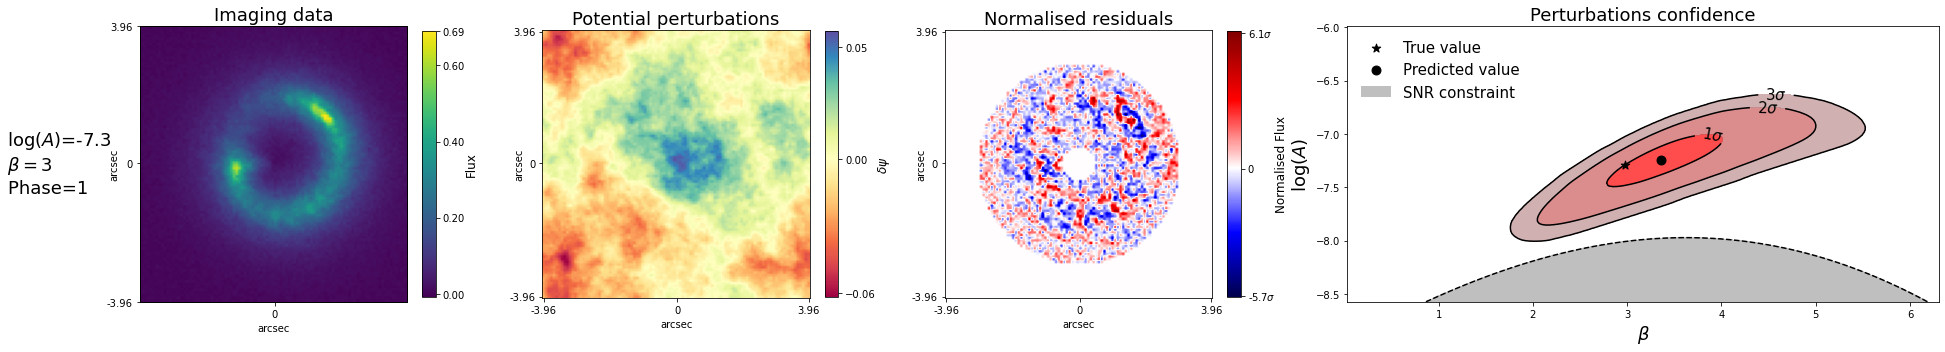

In [66]:
from matplotlib import gridspec
fig=plt.figure(figsize=(27,5))
gs = gridspec.GridSpec(1, 4,
                       width_ratios=[1,1,1,2],
                       height_ratios=[1])
ax=[]
for i in range(1):
    ax_row=[]
    for j in range(4):
        axis=plt.subplot(gs[4*i+j])
        ax_row+=[axis]
    ax+=[ax_row]
    
ax=np.array(ax)

plot_line(ax[0],data_image,data_image-fit_image,GRF_potential,likelihood,Confidence_grid,SNR,true_logA_index,true_Beta_index,pred_logA_index,pred_Beta_index,logA_ind_lim=(50,160),Beta_ind_lim=(0,150))
plt.tight_layout(h_pad=3,w_pad=2)